Nikko De Guzman - 302351054, Henry Ho 304723723, Koenrad MacBride - 305820663, Robert Rosas - 302233300, Justin Sarenas - 304675389

# League Rank Predictor

Uses Riot Developer's api V3 (https://developer.riotgames.com/) and seeded data to predict the "highest achieved season tier" for each player using the data from matches as features.

Features include:
-Role
-Kills
-Deaths
-Assists
-GoldEarned
-DamageDealtToObjectives
-TotalMinionsKilled

Labels include:
- UNRANKED
- BRONZE
- SILVER
- GOLD
- PLATINUM
- DIAMOND
- MASTERS

In [1]:
# Import pandas
import pandas as pd

## Create Dataframe using Riot's seeded data

In [2]:
# Creating empty dataframe
stats_df = pd.DataFrame()

### Parse seeded data

In [3]:
# Importing JSON
import json

# Function gets stats from seeded data and returns a dataframe
def get_stats(*files):
    df = pd.DataFrame()
    
    if len(files) == 1:
        df = parse_json(files)
    elif len(files) > 1:
        for file in files:
            df = df.append(parse_json(file), ignore_index=True)
            
    return df
        
# Function that parses json file into a dataframe
def parse_json(file):
    df = pd.DataFrame(columns = ['win', 'role', 'kills', 'deaths', 'assists', 'gameDuration', 'goldEarned', 'totalMinionsKilled', 'damageDealtToObjectives', 'totalDamageDealt', 'totalDamageTaken', 'wardsPlaced', 'highestAchievedSeasonTier'])
    matches = pd.read_json(path_or_buf=file)
    
    for match in matches['matches']:
        for participant in match['participants']:
            
            df = df.append({'win': participant['stats']['win'],
                            'role': participant['timeline']['role'],
                            'kills': participant['stats']['kills'],
                            'deaths': participant['stats']['deaths'],
                            'assists': participant['stats']['assists'],
                            'gameDuration': match['gameDuration'],
                            'goldEarned': participant['stats']['goldEarned'],
                            'totalMinionsKilled': participant['stats']['totalMinionsKilled'],
                            'damageDealtToObjectives': participant['stats']['damageDealtToObjectives'],
                            'totalDamageDealt': participant['stats']['totalDamageDealt'],
                            'totalDamageTaken': participant['stats']['totalDamageTaken'],
                            'wardsPlaced': participant['stats']['wardsPlaced'],
                            'highestAchievedSeasonTier': participant['highestAchievedSeasonTier']}, ignore_index=True)

    return df

In [4]:
# datasets = ['datasets/matches1.json', 'datasets/matches2.json', 'datasets/matches3.json', 
#             'datasets/matches4.json', 'datasets/matches5.json', 'datasets/matches6.json', 
#             'datasets/matches7.json', 'datasets/matches8.json', 'datasets/matches9.json', 
#             'datasets/matches10.json']

datasets = ['datasets/matches1.json', 'datasets/matches2.json', 'datasets/matches3.json',
            'datasets/matches4.json', 'datasets/matches5.json', 'datasets/matches6.json',
            'datasets/matches7.json', 'datasets/matches8.json', 'datasets/matches9.json',
            'datasets/matches10.json'
           ]
stats_df = get_stats(*datasets)
print(stats_df)

        win         role kills deaths assists gameDuration goldEarned  \
0      True         SOLO    17      5      25         3509      26248   
1      True    DUO_CARRY    24     14      15         3509      28906   
2      True  DUO_SUPPORT     8     17      22         3509      18845   
3      True         NONE     7      7      29         3509      19404   
4      True         SOLO    10     10      20         3509      20805   
5     False         NONE     8     15      12         3509      19921   
6     False         SOLO    14     13      12         3509      22644   
7     False  DUO_SUPPORT    11     15      16         3509      20659   
8     False    DUO_CARRY     8     12      18         3509      22493   
9     False         SOLO    12     11      13         3509      22368   
10    False         SOLO     3      8      14         3105      17936   
11    False  DUO_SUPPORT     8     10      16         3105      19876   
12    False    DUO_CARRY     9     12      14      

In [30]:
from sklearn import preprocessing
feature_matrix = ["role", "kills", "deaths", "assists","goldEarned", "totalMinionsKilled", "damageDealtToObjectives","totalDamageDealt"]
X = stats_df[feature_matrix]
Z = pd.get_dummies(X, columns=["role"])
#Z = preprocessing.scale(Z)
print(Z)


label_vector = stats_df["highestAchievedSeasonTier"]
print(label_vector)

     kills deaths assists goldEarned totalMinionsKilled  \
0       17      5      25      26248                373   
1       24     14      15      28906                403   
2        8     17      22      18845                 68   
3        7      7      29      19404                 86   
4       10     10      20      20805                287   
5        8     15      12      19921                 57   
6       14     13      12      22644                269   
7       11     15      16      20659                 95   
8        8     12      18      22493                285   
9       12     11      13      22368                226   
10       3      8      14      17936                232   
11       8     10      16      19876                175   
12       9     12      14      18803                263   
13       8     15      17      18682                142   
14      19     13      11      21040                246   
15       1      6      29      16889                 56 

In [63]:
df = pd.DataFrame()
df = pd.get_dummies(label_vector, columns=['highestAchievedSeasonTier']).sum()
print(df)

BRONZE      1404
DIAMOND      293
GOLD        2199
MASTER         8
PLATINUM    1107
SILVER      3010
UNRANKED    1979
dtype: int64


#KNN CLASSIFIER


In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Z, label_vector, test_size=0.3, random_state=3)

k = 83

knn = KNeighborsClassifier(n_neighbors = k) 

##Train with training set
knn.fit(X_train, y_train)

## Test with testing set
y_predict = knn.predict(X_test)

## Print results
results = pd.DataFrame()

results['Actual'] = y_test
results['Prediction'] = y_predict
print(results.head())

## Calculate accuracy from prediction
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_predict)

print('\n')
score = 'Accuracy: '
print('%s %lf' % (score, accuracy))

        Actual Prediction
5876  UNRANKED     SILVER
6555  PLATINUM     SILVER
1448      GOLD     SILVER
3351      GOLD     SILVER
231       GOLD       GOLD


Accuracy:  0.285000


LOGISTIC REGRESSION

In [48]:
## Logistic regression
from sklearn.linear_model import LogisticRegression

my_logreg = LogisticRegression()
my_logreg.fit(X_train, y_train)


resultsLR = pd.DataFrame()

y_predict_lr = my_logreg.predict(X_test)

resultsLR['Actual'] = y_test
resultsLR['Prediction'] = y_predict_lr
print(resultsLR.head())

accuracyLR = accuracy_score(y_test, y_predict_lr)

print('\n')
score = 'Accuracy: '
print('%s %lf' % (score, accuracyLR))



        Actual Prediction
5876  UNRANKED     SILVER
6555  PLATINUM     SILVER
1448      GOLD     SILVER
3351      GOLD     SILVER
231       GOLD     SILVER


Accuracy:  0.294000


In [45]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier
my_RandomForest = RandomForestClassifier(n_estimators = 1000, bootstrap = True, random_state=2)

my_RandomForest.fit(X_train, y_train)

y_predictRF = my_RandomForest.predict(X_test)

resultsRF = pd.DataFrame()

resultsRF['Actual'] = y_test
resultsRF['Prediction'] = y_predictRF
print(resultsRF)

accuracyRF = accuracy_score(y_test, y_predictRF)

print('\n')
score = 'Accuracy: '
print('%s %lf' % (score, accuracyRF))


      Actual  Prediction
0          0           3
1          6           6
2          6           6
3          3           7
4          7           7
5          7           0
6          7           6
7          3           0
8          7           7
9          7           6
10         5           6
11         6           6
12         5           6
13         6           0
14         2           3
15         6           6
16         7           6
17         5           6
18         3           6
19         7           6
20         3           6
21         6           6
22         5           7
23         0           0
24         3           7
25         2           6
26         0           6
27         0           6
28         3           6
29         2           6
...      ...         ...
2970       6           6
2971       7           0
2972       0           7
2973       3           6
2974       5           3
2975       0           3
2976       7           3
2977       5           6


In [56]:
#Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics
import numpy as np

le = preprocessing.LabelEncoder()
linreg = LinearRegression()

le.fit(["UNRANKED", "BRONZE", "SILVER", "GOLD", "PLATINUM", "DIAMOND", "MASTER", "CHALLENGER"])
Y = le.transform(label_vector)

X_train, X_test, y_train, y_test = train_test_split(Z, Y, test_size=0.3, random_state=2)

linreg.fit(X_train, y_train)


print('%s %lf'% ('Intercept: ', linreg.intercept_))
print( linreg.coef_)

y_prediction_linR = linreg.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_prediction_linR)
rmse = np.sqrt(mse)
print('%s %lf' % ('RMSE: ', rmse))


Intercept:  4.573270
[  6.73178074e-03   3.88329155e-03   2.90324326e-03  -2.10930451e-05
  -1.32121699e-04  -9.06941893e-06   1.36845756e-06   1.49775558e-01
  -1.07771006e-01   4.14770246e-02  -7.60113955e-02  -7.47018123e-03]
RMSE:  2.359339


Most important feature: Kills
Least important feature: Damage dealt to objectives

In [58]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# "my_decisiontree" is instantiated as an "object" of DecisionTreeCLassifier "class"

my_decisiontree = DecisionTreeClassifier()
my_decisiontree.fit(X_train, y_train)
y_predict_dt = my_decisiontree.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_predict_dt)

print(accuracy_dt)


0.227


CROSS-VALIDATION

C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for 

C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for 

KNN Mean Accuracy:  0.208514
KNN Mean Accuracy:  0.194304
KNN Mean Accuracy:  0.218103
KNN Mean Accuracy:  0.220506
KNN Mean Accuracy:  0.232499
KNN Mean Accuracy:  0.237795
KNN Mean Accuracy:  0.248695
KNN Mean Accuracy:  0.245099
KNN Mean Accuracy:  0.246596
KNN Mean Accuracy:  0.250702
KNN Mean Accuracy:  0.254607
KNN Mean Accuracy:  0.255503
KNN Mean Accuracy:  0.254107
KNN Mean Accuracy:  0.259808
KNN Mean Accuracy:  0.260714
KNN Mean Accuracy:  0.260314
KNN Mean Accuracy:  0.262214
KNN Mean Accuracy:  0.261714
KNN Mean Accuracy:  0.266108
KNN Mean Accuracy:  0.267010
KNN Mean Accuracy:  0.266509
KNN Mean Accuracy:  0.268606
KNN Mean Accuracy:  0.270304
KNN Mean Accuracy:  0.269505
KNN Mean Accuracy:  0.271397
KNN Mean Accuracy:  0.273601
KNN Mean Accuracy:  0.273600
KNN Mean Accuracy:  0.276800
KNN Mean Accuracy:  0.278102
KNN Mean Accuracy:  0.279608
KNN Mean Accuracy:  0.280611
KNN Mean Accuracy:  0.281010
KNN Mean Accuracy:  0.279206
KNN Mean Accuracy:  0.280209
KNN Mean Accur

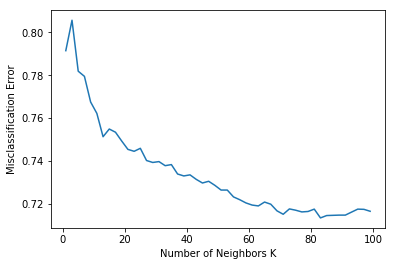

In [53]:
#Cross-validation with KNN
from sklearn import datasets
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn import linear_model
import matplotlib.pyplot as plt
#import cross validation library
from sklearn.cross_validation import cross_val_score

myList = list(range(1,100))
neighbors = [x for x in myList if x % 2 != 0]


accuracy_cvknn = []

for k in neighbors:
    newKNN = KNeighborsClassifier(n_neighbors = k)
    accuracy_listknn = cross_val_score(newKNN, Z, label_vector, cv=10, scoring='accuracy')
    accuracy_cvknn.append(accuracy_listknn.mean())

# score = 'KNN Mean Accuracy: '
# for i in accuracy_cvknn:
#     print('%s %lf' % (score, i))


MSE = [1 - x for x in accuracy_cvknn]

# determining best k
index = MSE.index(min(MSE))
optimal_k = neighbors[index]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()


In [54]:
#Cross-validation for Logistic Regression
cv_score = 'Cross-validation accuracy: '
accuracy_list = cross_val_score(my_logreg, Z, label_vector, cv=10, scoring='accuracy')
print(accuracy_list)
accuracy_cv = accuracy_list.mean()
print('%s %lf' % (cv_score, accuracy_cv))

C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


[ 0.29840319  0.29840319  0.30139721  0.3006993   0.3         0.302       0.301
  0.3013013   0.30160321  0.30120482]
Cross-validation accuracy:  0.300601


In [55]:
#Cross-validation for Linear Regression

crosslinreg = LinearRegression()
mse_list = cross_val_score(crosslinreg, Z, Y, cv =10, scoring='neg_mean_squared_error')

## converting to positive and and squaring
mse_list_positive = -mse_list

# using numpy sqrt function to calculate rmse:
rmse_list = np.sqrt(mse_list_positive)
#print(mse_list)
#print(rmse_list)
print('%s %lf' % ('RSME MEAN: ', rmse_list.mean()))

RSME MEAN:  2.337418


In [66]:
cross_decisiontree = DecisionTreeClassifier()
accuracy_list_DT = cross_val_score(cross_decisiontree, Z, label_vector, cv=10, scoring='accuracy')

print('%s %lf' % (cv_score, accuracy_list_DT.mean()))

C:\Users\Nikko\Anaconda3\lib\site-packages\sklearn\cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


Cross-validation accuracy:  0.214398
